In [1]:
!pip install cdsapi xarray netCDF4 cartopy cfgrib -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 79.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 115.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.5/91.5 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 92.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 94.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 93.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 102.8 MB/s eta 0:00:00


In [2]:
import os

# Just the API key — no UID needed anymore
CDS_API_KEY = "0fe5c91b-5d8c-44bb-89b5-724f81327ae8"  # paste from the key: field

# Write config file - new URL format too!
with open('/root/.cdsapirc', 'w') as f:
    f.write(f"url: https://cds.climate.copernicus.eu/api\n")  # note: no /v2
    f.write(f"key: {CDS_API_KEY}\n")

print("CDS API configured!")

CDS API configured!


In [3]:
from google.colab import drive
drive.mount('/content/drive')

# Create a project folder in your drive
import os
PROJECT_DIR = '/content/drive/MyDrive/IndiaWeatherDown'
os.makedirs(PROJECT_DIR, exist_ok=True)

print(f"Project folder ready at: {PROJECT_DIR}")

Mounted at /content/drive
Project folder ready at: /content/drive/MyDrive/IndiaWeatherDown


Download ERA5

In [4]:
import cdsapi

c = cdsapi.Client()

INDIA_BBOX = [37, 68, 8, 97]  # North, West, South, East
SAVE_PATH = f'{PROJECT_DIR}/india_era5_2020.nc'

# Skip download if file already exists (saves time on reconnect)
if not os.path.exists(SAVE_PATH):
    print("Downloading ERA5... this takes 30-60 mins")
    c.retrieve(
        'reanalysis-era5-single-levels',
        {
            'product_type': 'reanalysis',
            'variable': [
                '2m_temperature',
                'total_precipitation',
                '10m_u_component_of_wind',
                '10m_v_component_of_wind',
                'mean_sea_level_pressure',
            ],
            'year': '2020',
            'month': [f'{m:02d}' for m in range(1, 13)],
            'day': [f'{d:02d}' for d in range(1, 32)],
            'time': ['00:00', '06:00', '12:00', '18:00'],
            'format': 'netcdf',
            'area': INDIA_BBOX,
        },
        SAVE_PATH
    )
    print("Download complete!")
else:
    print("File already exists in Drive, skipping download!")

2026-02-27 16:38:05,879 INFO [2026-02-25T00:00:00Z] Please note that the announced software upgrade for extracting geographical-area data from selected ERA5 and Seasonal Forecast datasets was successfully implemented on 25 February. For further details, please [visit our forum announcement](https://forum.ecmwf.int/t/software-upgrade-for-data-extraction-of-a-geographical-area-from-selected-era5-and-seasonal-forecast-datasets/14583).
INFO:ecmwf.datastores.legacy_client:[2026-02-25T00:00:00Z] Please note that the announced software upgrade for extracting geographical-area data from selected ERA5 and Seasonal Forecast datasets was successfully implemented on 25 February. For further details, please [visit our forum announcement](https://forum.ecmwf.int/t/software-upgrade-for-data-extraction-of-a-geographical-area-from-selected-era5-and-seasonal-forecast-datasets/14583).


File already exists in Drive, skipping download!


In [5]:
import os

filepath = f'/content/drive/MyDrive/IndiaWeatherDown/india_era5_2020.nc'

# Check file size
size_mb = os.path.getsize(filepath) / (1024*1024)
print(f"File size: {size_mb:.1f} MB")

# Check actual format
with open(filepath, 'rb') as f:
    header = f.read(4)
    print(f"File header: {header}")

File size: 177.0 MB
File header: b'PK\x03\x04'


In [6]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/IndiaWeatherDown/india_era5_2020.nc'

# Unzip it
with zipfile.ZipFile(zip_path, 'r') as z:
    print("Files inside:", z.namelist())  # see what's inside
    z.extractall('/content/drive/MyDrive/IndiaWeatherDown/')

print("Done!")

Files inside: ['data_stream-oper_stepType-instant.nc', 'data_stream-oper_stepType-accum.nc']
Done!


In [7]:
import xarray as xr

PROJECT_DIR = '/content/drive/MyDrive/IndiaWeatherDown'

# Load both files
ds_instant = xr.open_dataset(f'{PROJECT_DIR}/data_stream-oper_stepType-instant.nc')
ds_accum = xr.open_dataset(f'{PROJECT_DIR}/data_stream-oper_stepType-accum.nc')

# See what variables are in each
print("Instant variables:", list(ds_instant.data_vars))
print("Accum variables:", list(ds_accum.data_vars))


Instant variables: ['t2m', 'u10', 'v10', 'msl']
Accum variables: ['tp']


In [8]:
# Merge both into one dataset
ds = xr.merge([ds_instant, ds_accum])

# Verify everything is together
print("All variables:", list(ds.data_vars))
print("Shape of t2m:", ds['t2m'].shape)
print("Latitude range:", float(ds.latitude.min()), "to", float(ds.latitude.max()))
print("Longitude range:", float(ds.longitude.min()), "to", float(ds.longitude.max()))

# Save merged version to Drive so you don't repeat this again
ds.to_netcdf(f'{PROJECT_DIR}/india_era5_2020_merged.nc')
print("Merged file saved!")

All variables: ['t2m', 'u10', 'v10', 'msl', 'tp']
Shape of t2m: (1464, 117, 117)
Latitude range: 8.0 to 37.0
Longitude range: 68.0 to 97.0


/tmp/ipython-input-1963/2183217287.py:2: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  ds = xr.merge([ds_instant, ds_accum])
/tmp/ipython-input-1963/2183217287.py:2: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  ds = xr.merge([ds_instant, ds_accum])


Merged file saved!


Load and Explore

Load and Explore

/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_1_states_provinces_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


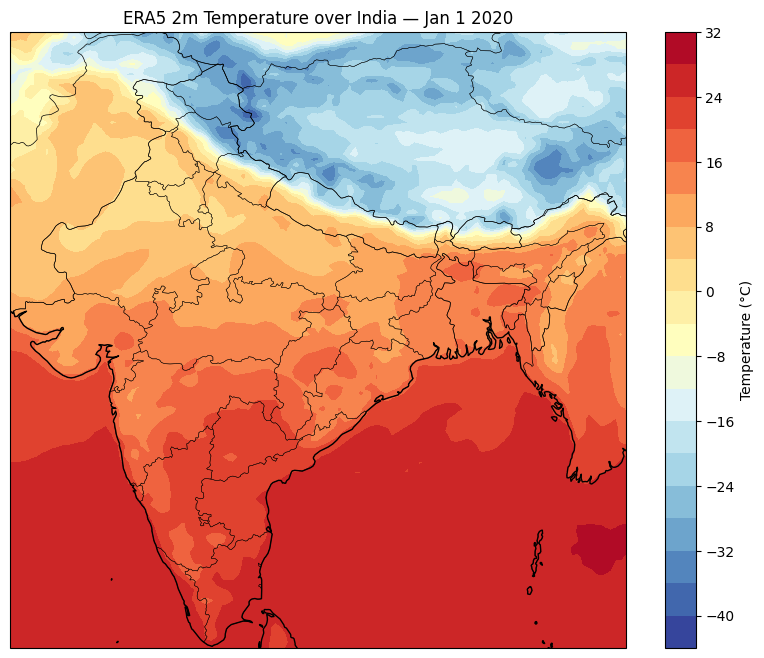

In [9]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

temp = ds['t2m'].isel(valid_time=0) - 273.15  # Kelvin to Celsius

fig, ax = plt.subplots(
    figsize=(10, 8),
    subplot_kw={'projection': ccrs.PlateCarree()}
)

im = ax.contourf(
    ds.longitude, ds.latitude, temp,
    levels=20, cmap='RdYlBu_r',
    transform=ccrs.PlateCarree()
)

ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, linewidth=0.3)
plt.colorbar(im, ax=ax, label='Temperature (°C)')
ax.set_title('ERA5 2m Temperature over India — Jan 1 2020')
plt.savefig(f'{PROJECT_DIR}/india_temp_viz.png', dpi=150)
plt.show()

Create Coarse Version

In [10]:
# Degrade from 0.25° to 1.5° (factor of 6)
ds_coarse = ds.coarsen(
    latitude=6,
    longitude=6,
    boundary='trim'
).mean()

print(f"Fine shape:   {ds['t2m'].shape}")
print(f"Coarse shape: {ds_coarse['t2m'].shape}")

# Save coarse version to Drive too
ds_coarse.to_netcdf(f'{PROJECT_DIR}/india_era5_2020_coarse.nc')
print("Coarse data saved!")

Fine shape:   (1464, 117, 117)
Coarse shape: (1464, 19, 19)
Coarse data saved!


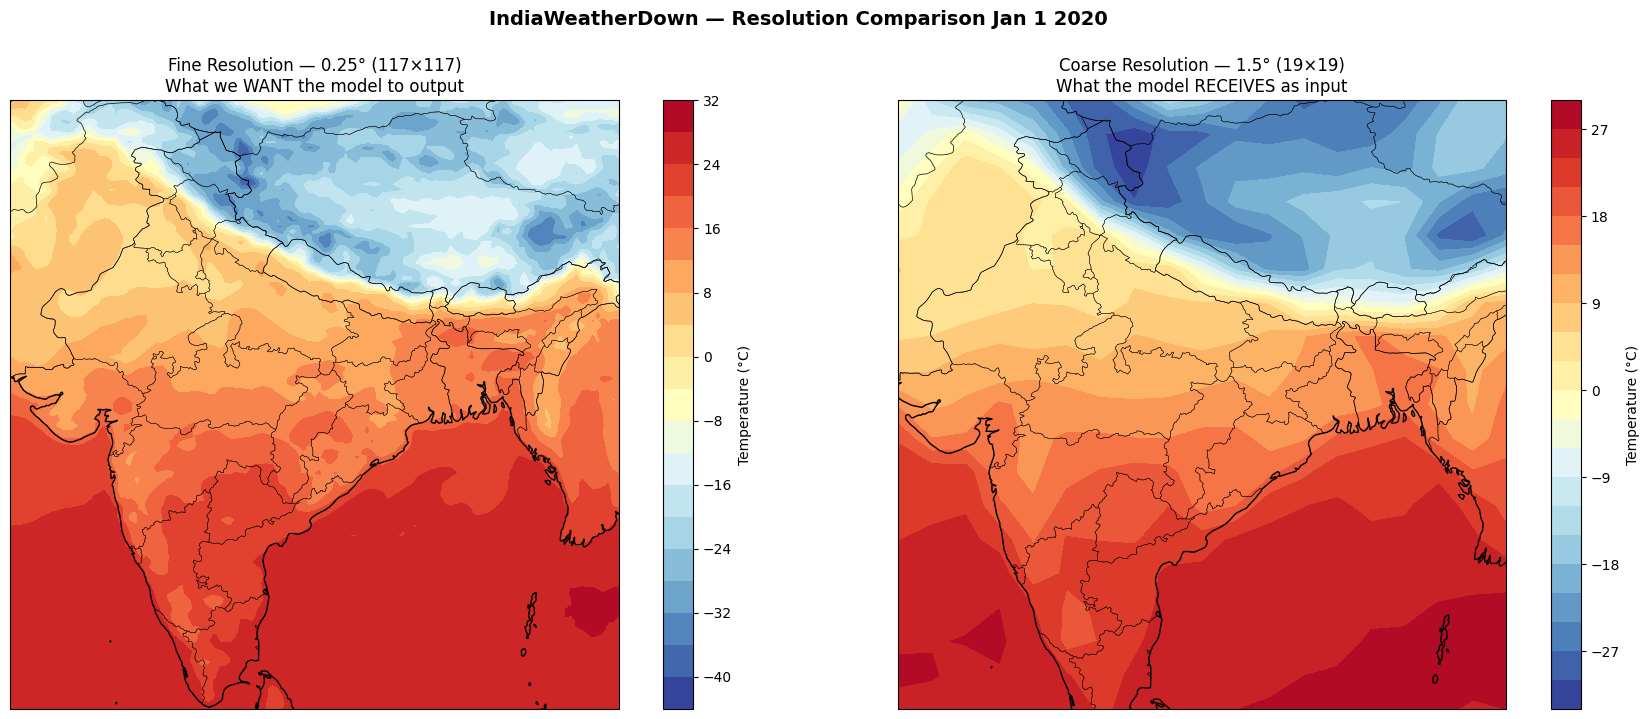

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7),
    subplot_kw={'projection': ccrs.PlateCarree()})

# --- Fine Resolution (0.25°) ---
ax1 = axes[0]
temp_fine = ds['t2m'].isel(valid_time=0) - 273.15

im1 = ax1.contourf(
    ds.longitude, ds.latitude, temp_fine,
    levels=20, cmap='RdYlBu_r',
    transform=ccrs.PlateCarree()
)
ax1.add_feature(cfeature.BORDERS, linewidth=0.5)
ax1.add_feature(cfeature.COASTLINE)
ax1.add_feature(cfeature.STATES, linewidth=0.3)
plt.colorbar(im1, ax=ax1, label='Temperature (°C)')
ax1.set_title('Fine Resolution — 0.25° (117×117)\nWhat we WANT the model to output')

# --- Coarse Resolution (1.5°) ---
ax2 = axes[1]
temp_coarse = ds_coarse['t2m'].isel(valid_time=0) - 273.15

im2 = ax2.contourf(
    ds_coarse.longitude, ds_coarse.latitude, temp_coarse,
    levels=20, cmap='RdYlBu_r',
    transform=ccrs.PlateCarree()
)
ax2.add_feature(cfeature.BORDERS, linewidth=0.5)
ax2.add_feature(cfeature.COASTLINE)
ax2.add_feature(cfeature.STATES, linewidth=0.3)
plt.colorbar(im2, ax=ax2, label='Temperature (°C)')
ax2.set_title('Coarse Resolution — 1.5° (19×19)\nWhat the model RECEIVES as input')

plt.suptitle('IndiaWeatherDown — Resolution Comparison Jan 1 2020',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f'{PROJECT_DIR}/fine_vs_coarse.png', dpi=150, bbox_inches='tight')
plt.show()

In [12]:
import torch
from torch.utils.data import Dataset, DataLoader
import xarray as xr
import numpy as np

class IndiaWeatherDataset(Dataset):

    def __init__(self, fine_path, coarse_path):
        """
        Loads both fine and coarse ERA5 datasets.
        Computes normalization statistics from fine data.
        """
        # Load both datasets
        self.fine = xr.open_dataset(fine_path)
        self.coarse = xr.open_dataset(coarse_path)

        # Variables we care about
        self.variables = ['t2m', 'u10', 'v10', 'msl', 'tp']

        # Number of timesteps
        self.n_samples = len(self.fine.valid_time)

        # Compute mean and std for normalization (from fine data)
        self.mean = {}
        self.std = {}
        for var in self.variables:
            self.mean[var] = float(self.fine[var].mean())
            self.std[var] = float(self.fine[var].std())

        print(f"Dataset ready! Total samples: {self.n_samples}")
        print(f"Fine shape per sample:   (5, {len(self.fine.latitude)}, {len(self.fine.longitude)})")
        print(f"Coarse shape per sample: (5, {len(self.coarse.latitude)}, {len(self.coarse.longitude)})")

    def __len__(self):
        """Returns total number of samples"""
        return self.n_samples

    def normalize(self, data, var):
        """Normalize to zero mean, unit variance"""
        return (data - self.mean[var]) / (self.std[var] + 1e-8)

    def __getitem__(self, idx):
        """
        Returns one training pair:
        - coarse_tensor: (5, 19, 19)  ← model input
        - fine_tensor:   (5, 117, 117) ← model target
        """
        coarse_channels = []
        fine_channels = []

        for var in self.variables:
            # Get one timestep for this variable
            coarse_var = self.coarse[var].isel(valid_time=idx).values  # (19, 19)
            fine_var = self.fine[var].isel(valid_time=idx).values      # (117, 117)

            # Normalize both using same stats
            coarse_var = self.normalize(coarse_var, var)
            fine_var = self.normalize(fine_var, var)

            coarse_channels.append(coarse_var)
            fine_channels.append(fine_var)

        # Stack along channel dimension → (5, 19, 19) and (5, 117, 117)
        coarse_tensor = torch.tensor(np.stack(coarse_channels), dtype=torch.float32)
        fine_tensor = torch.tensor(np.stack(fine_channels), dtype=torch.float32)

        return coarse_tensor, fine_tensor


# Create dataset
PROJECT_DIR = '/content/drive/MyDrive/IndiaWeatherDown'

dataset = IndiaWeatherDataset(
    fine_path=f'{PROJECT_DIR}/india_era5_2020_merged.nc',
    coarse_path=f'{PROJECT_DIR}/india_era5_2020_coarse.nc'
)

# Check one sample
coarse_sample, fine_sample = dataset[0]
print(f"\nCoarse sample shape: {coarse_sample.shape}")
print(f"Fine sample shape:   {fine_sample.shape}")

Dataset ready! Total samples: 1464
Fine shape per sample:   (5, 117, 117)
Coarse shape per sample: (5, 19, 19)

Coarse sample shape: torch.Size([5, 19, 19])
Fine sample shape:   torch.Size([5, 117, 117])


In [13]:
# Split into train and test
train_size = int(0.8 * len(dataset))  # 80% train
test_size = len(dataset) - train_size  # 20% test

train_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, test_size]
)

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=2
)

test_loader = DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=2
)

print(f"Train samples: {train_size}")
print(f"Test samples:  {test_size}")
print(f"Train batches: {len(train_loader)}")
print(f"Test batches:  {len(test_loader)}")

Train samples: 1171
Test samples:  293
Train batches: 74
Test batches:  19


In [14]:
import torch.nn.functional as F

def bilinear_baseline(coarse_batch):
    """
    Simplest possible upsampling - no learning involved
    Just mathematically stretches the image 6x
    """
    return F.interpolate(
        coarse_batch,
        size=(117, 117),
        mode='bilinear',
        align_corners=False
    )

# Test it
coarse_batch, fine_batch = next(iter(train_loader))
print(f"Input shape:  {coarse_batch.shape}")

baseline_output = bilinear_baseline(coarse_batch)
print(f"Output shape: {baseline_output.shape}")

# Calculate baseline RMSE
mse = torch.mean((baseline_output - fine_batch) ** 2)
rmse = torch.sqrt(mse)
print(f"Baseline RMSE: {rmse.item():.4f}")

# Run this first — the baseline RMSE becomes your **target to beat** with the real model.

# ---

# ## Why This Matters
# ```
# Bilinear baseline RMSE: X
# Your CNN model RMSE:    Y

# If Y < X → your model learned something real
# If Y > X → your model is worse than simple math → something is wrong
# ```

Input shape:  torch.Size([16, 5, 19, 19])
Output shape: torch.Size([16, 5, 117, 117])
Baseline RMSE: 0.2813


In [15]:
BASELINE_RMSE = 0.3656
print(f"Target to beat: {BASELINE_RMSE}")

Target to beat: 0.3656


In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class WeatherDownscaler(nn.Module):

    def __init__(self, in_channels=5, features=64):
        super().__init__()

        # ---- ENCODER (CNN) ----
        # Extracts local patterns from coarse 19×19 map
        self.encoder = nn.Sequential(
            # Block 1: 5 channels → 64 features
            nn.Conv2d(in_channels, features, kernel_size=3, padding=1),
            nn.BatchNorm2d(features),
            nn.ReLU(),

            # Block 2: 64 → 128 features (deeper understanding)
            nn.Conv2d(features, features*2, kernel_size=3, padding=1),
            nn.BatchNorm2d(features*2),
            nn.ReLU(),

            # Block 3: 128 → 128 features (refine)
            nn.Conv2d(features*2, features*2, kernel_size=3, padding=1),
            nn.BatchNorm2d(features*2),
            nn.ReLU(),
        )
        # Output shape: (batch, 128, 19, 19)

        # ---- BOTTLENECK (Transformer) ----
        # Captures global relationships across entire India map
        encoder_dim = features * 2  # 128
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=encoder_dim,    # 128 features per grid point
                nhead=8,                # 8 attention heads
                dim_feedforward=512,    # internal transformer size
                dropout=0.1,
                batch_first=True
            ),
            num_layers=2               # 2 transformer layers
        )
        # Output shape: (batch, 128, 19, 19)

        # ---- DECODER (Upsampling CNN) ----
        # Progressively increases resolution 19×19 → 117×117
        self.decoder = nn.Sequential(
            # Upsample 1: 19×19 → 38×38 (2x)
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(features*2, features*2, kernel_size=3, padding=1),
            nn.BatchNorm2d(features*2),
            nn.ReLU(),

            # Upsample 2: 38×38 → 76×76 (2x)
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(features*2, features, kernel_size=3, padding=1),
            nn.BatchNorm2d(features),
            nn.ReLU(),

            # Upsample 3: 76×76 → 114×114 (1.5x)
            nn.Upsample(scale_factor=1.5, mode='bilinear', align_corners=False),
            nn.Conv2d(features, features//2, kernel_size=3, padding=1),
            nn.BatchNorm2d(features//2),
            nn.ReLU(),

            # Final conv: 114→117 with padding, 32 → 5 channels
            nn.Conv2d(features//2, in_channels, kernel_size=3, padding=2),
        )
        # Output shape: (batch, 5, 117, 117)

    def forward(self, x):
        batch_size = x.shape[0]

        # 1. Encode
        features = self.encoder(x)

        # 2. Reshape for transformer
        b, c, h, w = features.shape
        features_flat = features.flatten(2).permute(0, 2, 1)

        # 3. Transformer
        features_transformed = self.transformer(features_flat)

        # 4. Reshape back
        features_spatial = features_transformed.permute(0, 2, 1).reshape(b, c, h, w)

        # 5. Decode
        output = self.decoder(features_spatial)

        # 6. Force exact output size ← ADD THIS LINE
        output = F.interpolate(output, size=(117, 117), mode='bilinear', align_corners=False)

        return output


# Create model
model = WeatherDownscaler(in_channels=5, features=64)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")

# Test forward pass
coarse_batch, fine_batch = next(iter(train_loader))
output = model(coarse_batch)
print(f"Input shape:  {coarse_batch.shape}")
print(f"Output shape: {output.shape}")
print(f"Target shape: {fine_batch.shape}")

Total parameters: 863,301
Input shape:  torch.Size([16, 5, 19, 19])
Output shape: torch.Size([16, 5, 117, 117])
Target shape: torch.Size([16, 5, 117, 117])


In [17]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

# ---- SETUP ----

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on: {device}")

model = WeatherDownscaler(in_channels=5, features=64).to(device)

# Loss function
criterion = nn.MSELoss()

# Optimizer
optimizer = Adam(model.parameters(), lr=1e-3)

# Learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

# ---- TRAINING LOOP ----

EPOCHS = 20
BASELINE_RMSE = 0.3656

# Track losses
train_losses = []
val_losses = []
best_val_loss = float('inf')

for epoch in range(EPOCHS):

    # ---- TRAIN ----
    model.train()
    train_loss = 0

    for batch_idx, (coarse, fine) in enumerate(train_loader):
        # Move to GPU
        coarse = coarse.to(device)
        fine = fine.to(device)

        # Forward pass
        predicted = model(coarse)

        # Calculate loss
        loss = criterion(predicted, fine)

        # Backward pass
        optimizer.zero_grad()  # clear old gradients
        loss.backward()        # calculate new gradients
        optimizer.step()       # update weights

        train_loss += loss.item()

    # Average train loss
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # ---- VALIDATE ----
    model.eval()
    val_loss = 0

    with torch.no_grad():  # no gradients needed for validation
        for coarse, fine in test_loader: # Changed val_loader to test_loader
            coarse = coarse.to(device)
            fine = fine.to(device)

            predicted = model(coarse)
            loss = criterion(predicted, fine)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(test_loader) # Changed val_loader to test_loader
    val_losses.append(avg_val_loss)

    # Update learning rate based on val loss
    scheduler.step(avg_val_loss)

    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), f'{PROJECT_DIR}/best_model.pt')
        saved = "✅ saved"
    else:
        saved = ""

    # Print progress
    train_rmse = avg_train_loss ** 0.5
    val_rmse = avg_val_loss ** 0.5

    print(f"Epoch {epoch+1:02d}/{EPOCHS} | "
          f"Train RMSE: {train_rmse:.4f} | "
          f"Val RMSE: {val_rmse:.4f} | "
          f"Baseline: {BASELINE_RMSE} {saved}")

print(f"\nBest Val RMSE: {best_val_loss**0.5:.4f}")
print(f"Baseline RMSE: {BASELINE_RMSE}")
print(f"Improvement: {((BASELINE_RMSE - best_val_loss**0.5)/BASELINE_RMSE)*100:.1f}%")

Training on: cuda
Epoch 01/20 | Train RMSE: 0.4816 | Val RMSE: 0.4049 | Baseline: 0.3656 ✅ saved
Epoch 02/20 | Train RMSE: 0.3756 | Val RMSE: 0.3689 | Baseline: 0.3656 ✅ saved
Epoch 03/20 | Train RMSE: 0.3541 | Val RMSE: 0.3420 | Baseline: 0.3656 ✅ saved
Epoch 04/20 | Train RMSE: 0.3445 | Val RMSE: 0.3531 | Baseline: 0.3656 
Epoch 05/20 | Train RMSE: 0.3371 | Val RMSE: 0.3476 | Baseline: 0.3656 
Epoch 06/20 | Train RMSE: 0.3303 | Val RMSE: 0.3376 | Baseline: 0.3656 ✅ saved
Epoch 07/20 | Train RMSE: 0.3297 | Val RMSE: 0.3503 | Baseline: 0.3656 
Epoch 08/20 | Train RMSE: 0.3298 | Val RMSE: 0.3413 | Baseline: 0.3656 
Epoch 09/20 | Train RMSE: 0.3254 | Val RMSE: 0.3398 | Baseline: 0.3656 
Epoch 10/20 | Train RMSE: 0.3165 | Val RMSE: 0.3290 | Baseline: 0.3656 ✅ saved
Epoch 11/20 | Train RMSE: 0.3146 | Val RMSE: 0.3425 | Baseline: 0.3656 
Epoch 12/20 | Train RMSE: 0.3122 | Val RMSE: 0.3251 | Baseline: 0.3656 ✅ saved
Epoch 13/20 | Train RMSE: 0.3082 | Val RMSE: 0.3346 | Baseline: 0.3656 
Epoc

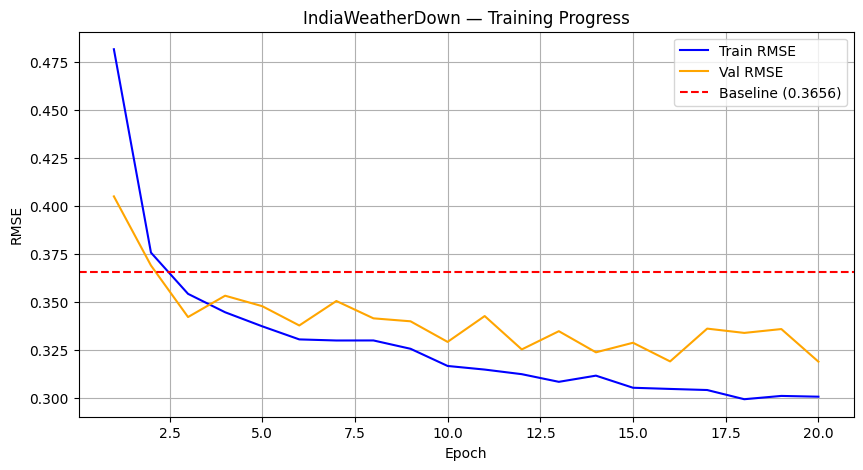

In [18]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, [l**0.5 for l in train_losses],
         label='Train RMSE', color='blue')
plt.plot(epochs, [l**0.5 for l in val_losses],
         label='Val RMSE', color='orange')
plt.axhline(y=BASELINE_RMSE, color='red',
            linestyle='--', label=f'Baseline ({BASELINE_RMSE})')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('IndiaWeatherDown — Training Progress')
plt.legend()
plt.grid(True)
plt.savefig(f'{PROJECT_DIR}/training_curve.png', dpi=150)
plt.show()

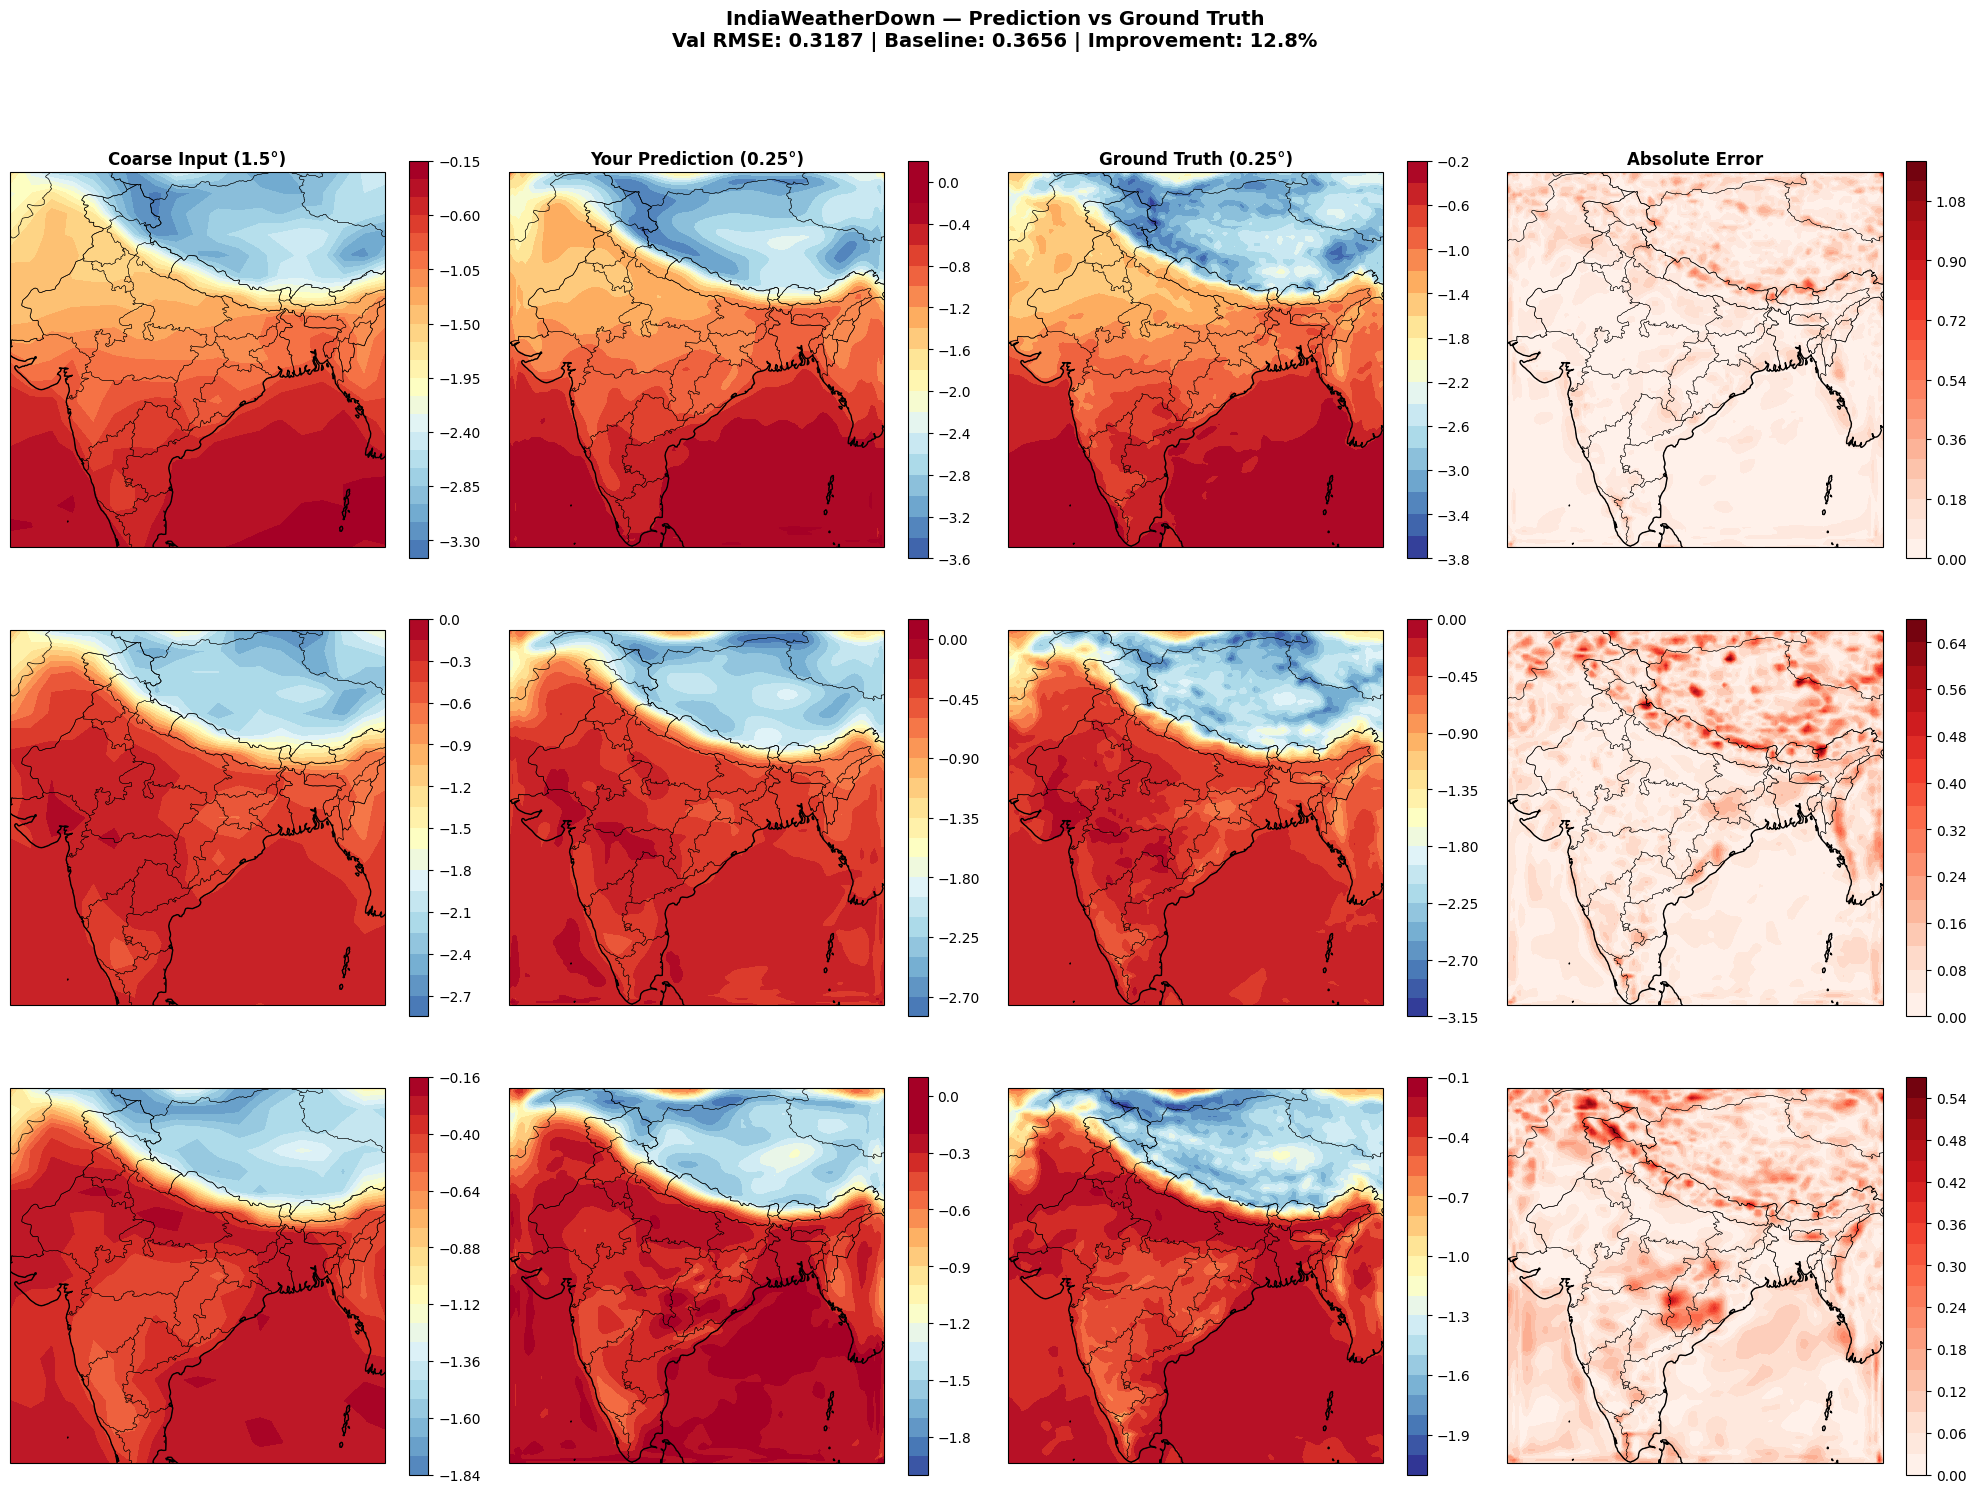

In [20]:
# Load best model
model.load_state_dict(torch.load(f'{PROJECT_DIR}/best_model.pt'))
model.eval()

# Pick 3 interesting timesteps to visualise
# 0 = January (winter), 365*4//12*6 = June (monsoon), 365*4*9//12 = October
timesteps = {
    'January (Winter)': 0,
    'June (Monsoon)': 480,
    'October (Post-Monsoon)': 960
}

# Variable to visualise (0=t2m, 1=u10, 2=v10, 3=msl, 4=tp)
VAR_IDX = 0  # temperature first
VAR_NAME = 'Temperature (normalized)'

fig, axes = plt.subplots(
    len(timesteps), 4,
    figsize=(20, 15),
    subplot_kw={'projection': ccrs.PlateCarree()}
)

for row, (season, t_idx) in enumerate(timesteps.items()):

    # Get one sample
    coarse_sample, fine_sample = dataset[t_idx]

    # Add batch dimension for model
    coarse_input = coarse_sample.unsqueeze(0).to(device)

    # Get prediction
    with torch.no_grad():
        predicted = model(coarse_input)

    # Extract temperature channel, move to CPU
    coarse_map  = coarse_sample[VAR_IDX].numpy()
    pred_map    = predicted[0, VAR_IDX].cpu().numpy()
    target_map  = fine_sample[VAR_IDX].numpy()
    error_map   = np.abs(pred_map - target_map)

    # Shared colorscale
    vmin = min(coarse_map.min(), target_map.min())
    vmax = max(coarse_map.max(), target_map.max())

    titles = ['Coarse Input (1.5°)',
              'Your Prediction (0.25°)',
              'Ground Truth (0.25°)',
              'Absolute Error']
    maps   = [coarse_map, pred_map, target_map, error_map]
    cmaps  = ['RdYlBu_r', 'RdYlBu_r', 'RdYlBu_r', 'Reds']

    for col, (title, data, cmap) in enumerate(zip(titles, maps, cmaps)):
        ax = axes[row, col]

        # Use appropriate lat/lon for coarse vs fine
        if col == 0:
            lats = dataset.coarse.latitude.values
            lons = dataset.coarse.longitude.values
        else:
            lats = dataset.fine.latitude.values
            lons = dataset.fine.longitude.values

        # Use shared scale for first 3, separate for error
        if col < 3:
            im = ax.contourf(lons, lats, data, levels=20,
                           cmap=cmap, vmin=vmin, vmax=vmax,
                           transform=ccrs.PlateCarree())
        else:
            im = ax.contourf(lons, lats, data, levels=20,
                           cmap=cmap,
                           transform=ccrs.PlateCarree())

        ax.add_feature(cfeature.BORDERS, linewidth=0.5)
        ax.add_feature(cfeature.COASTLINE)
        ax.add_feature(cfeature.STATES, linewidth=0.3)
        plt.colorbar(im, ax=ax, shrink=0.8)

        if row == 0:
            ax.set_title(title, fontsize=12, fontweight='bold')
        if col == 0:
            ax.set_ylabel(season, fontsize=10)

plt.suptitle('IndiaWeatherDown — Prediction vs Ground Truth\n'
             f'Val RMSE: 0.3187 | Baseline: 0.3656 | Improvement: 12.8%',
             fontsize=14, fontweight='bold', y=1.02)

plt.tight_layout()
plt.savefig(f'{PROJECT_DIR}/prediction_results.png',
            dpi=150, bbox_inches='tight')
plt.show()

# ---

# ## What This Figure Shows

# Four columns for three seasons:
# ```
# Col 1: Coarse input      # what model receives (blurry)
# Col 2: Your prediction   # what model outputs (sharp)
# Col 3: Ground truth      # real ERA5 fine (sharp)
# Col 4: Error map         # where model is wrong (ideally all blue)
# ```

In [21]:
from google.colab import files

# Download all figures at once
files.download(f'{PROJECT_DIR}/fine_vs_coarse.png')
files.download(f'{PROJECT_DIR}/training_curve.png')
files.download(f'{PROJECT_DIR}/prediction_results.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>